# Лабораторная работа 2. Ассоциативные правила

---

**Цель работы**: исследование методов анализа ассоциативных правил.

**Вариант датасета**: 3

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

import pandas as pd

all_data = pd.read_csv('DataSetA.csv', on_bad_lines='skip')
print(all_data)

       Lassi  Coffee Powder         Butter        Yougurt    Ghee Cheese  \
0       Ghee  Coffee Powder            NaN            NaN     NaN    NaN   
1      Lassi     Tea Powder         Butter         Cheese     NaN    NaN   
2     Cheese     Tea Powder         Panner  Coffee Powder  Butter  Bread   
3     Cheese        Yougurt  Coffee Powder          Sugar  Butter  Sweet   
4      Sugar     Tea Powder           Ghee          Sweet  Panner   Milk   
...      ...            ...            ...            ...     ...    ...   
8726  Panner          Sugar          Bread           Milk  Cheese    NaN   
8727   Sugar          Bread  Coffee Powder         Cheese     NaN    NaN   
8728   Bread         Cheese        Yougurt           Milk     NaN    NaN   
8729    Ghee          Bread        Yougurt          Sugar  Cheese    NaN   
8730  Panner        Yougurt          Bread            NaN     NaN    NaN   

      Unnamed: 6  
0            NaN  
1            NaN  
2            NaN  
3          

#### Анализ транзакций

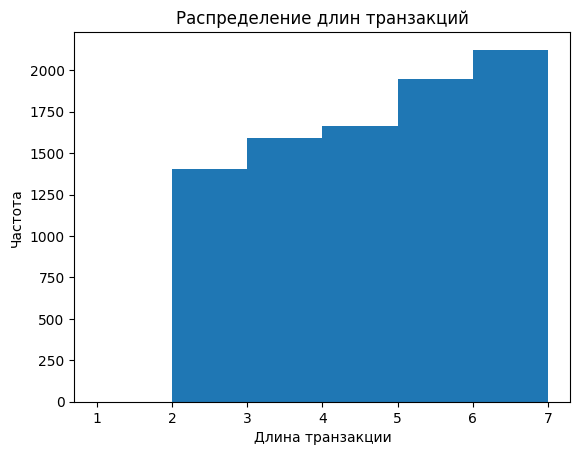

Минимальная длина транзакции: 2
Максимальная длина транзакции: 6
Средняя длина транзакции: 4.21
Медиана длины транзакции: 4.0


In [3]:
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

print(f"Минимальная длина транзакции: {transaction_lengths.min()}")
print(f"Максимальная длина транзакции: {transaction_lengths.max()}")
print(f"Средняя длина транзакции: {transaction_lengths.mean():.2f}")
print(f"Медиана длины транзакции: {transaction_lengths.median()}")

#### Очистка данных

In [4]:

np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]

#### Список уникальных товаров

In [5]:
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(f"Уникальных товаров: {len(unique_items)}")
print(unique_items)

te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

Уникальных товаров: 12
{'Milk', 'Panner', 'Sugar', 'Tea Powder', 'Sweet', 'Ghee', 'Yougurt', 'Lassi', 'Cheese', 'Bread', 'Coffee Powder', 'Butter'}


#### Алгоритм Apriori

---

In [6]:
df1 = apriori(data, min_support=0.07, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.27)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


     support                  itemsets
0   0.268583                   (Bread)
1   0.264002                  (Butter)
2   0.271561                  (Cheese)
3   0.269729           (Coffee Powder)
4   0.274654                    (Ghee)
5   0.261711                   (Lassi)
6   0.271332                    (Milk)
7   0.263429                  (Panner)
8   0.262856                   (Sugar)
9   0.267209                   (Sweet)
10  0.259993              (Tea Powder)
11  0.270988                 (Yougurt)
12  0.070782           (Bread, Cheese)
13  0.071355    (Bread, Coffee Powder)
14  0.071813           (Bread, Panner)
15  0.070553          (Bread, Yougurt)
16  0.072386            (Ghee, Butter)
17  0.070324         (Yougurt, Butter)
18  0.070210   (Coffee Powder, Cheese)
19  0.071469            (Ghee, Cheese)
20  0.071469            (Milk, Cheese)
21  0.071928           (Sweet, Cheese)
22  0.072271         (Yougurt, Cheese)
23  0.075707     (Ghee, Coffee Powder)
24  0.070439     (Milk, C

###### Анализ полученных результатов

Было найдено 9 ассоциативных правил у которых поддержка > 0.07 и  достоверность > 0,27

Интерпретация значений:
- Lift > 1 - сильная ассоциация между товарами
- Lift = 1 - ассоциация отсутствует
- Lift < 1 - наличие одного снижает вероятность появления другого

У всех ассоциативных правил lift практически равен 1, что можно сказать, что ассоциации практически отсутвуют

Классификация ассоциативных правил: полезные и тривиальные
Тривиальными правилами можно назвать:
- (Panner) и (Bread), тк к хлебу скорее всего купят сыр
- (Butter) и (Ghee), тк масла находятся в одном отделе
- (Lassi) и (Sweet), к напитку купят сладость

Остальные ассоциациативные правила можно назвать полезными

##### Поддержка и топ-10 самых популярных продуктов

     support       itemsets
4   0.274654           Ghee
2   0.271561         Cheese
6   0.271332           Milk
11  0.270988        Yougurt
3   0.269729  Coffee Powder
0   0.268583          Bread
9   0.267209          Sweet
1   0.264002         Butter
7   0.263429         Panner
8   0.262856          Sugar
5   0.261711          Lassi
10  0.259993     Tea Powder


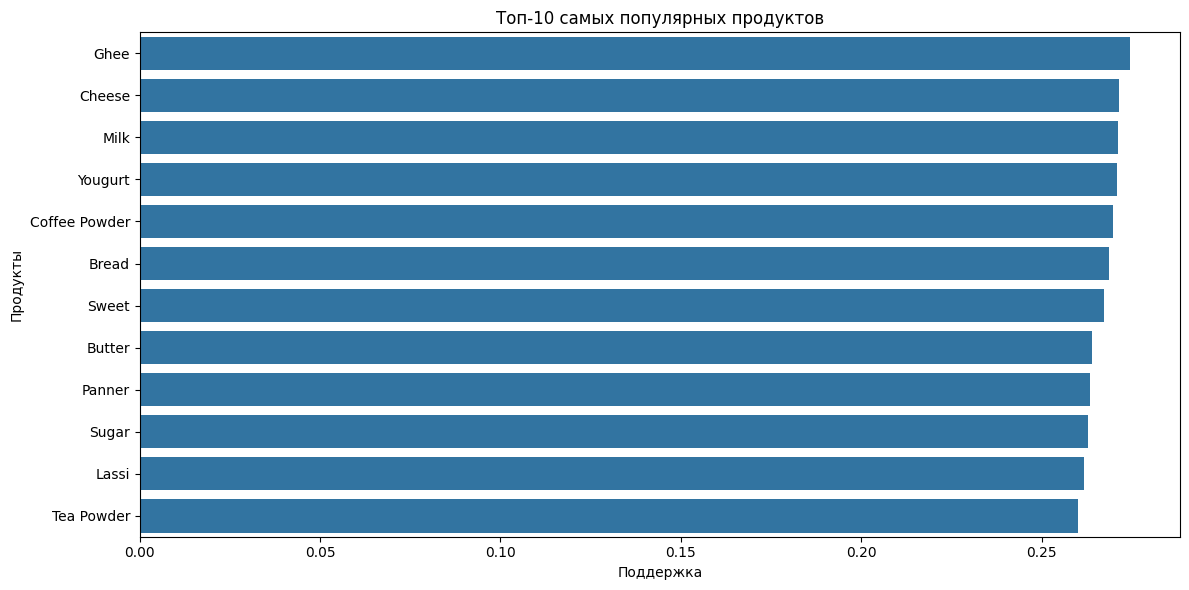

Средняя поддержка для продуктов: 0.267171


In [7]:
df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(12)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

print(f"Средняя поддержка для продуктов: {top_products['support'].mean():.6f}")


**Вывод**: cамое высокое значение support среди товаров имеет Gnee (0.274654), в основном поддержка у большинства одиночных товаров ≈ 0.267171

##### График достоверности используемых правил

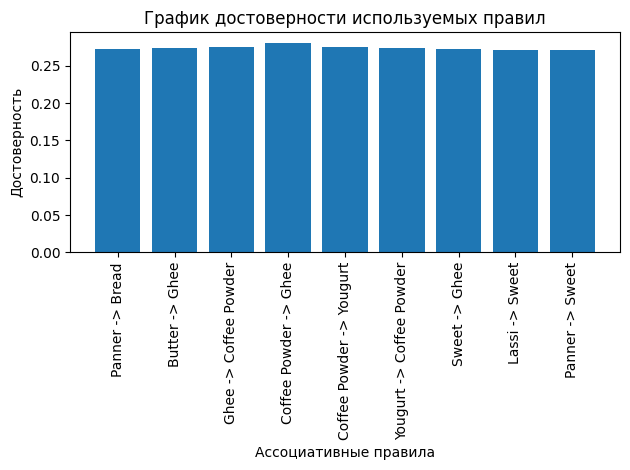

In [8]:
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


##### Визуализация ассоциативных правил в виде графа

<Figure size 1200x800 with 0 Axes>

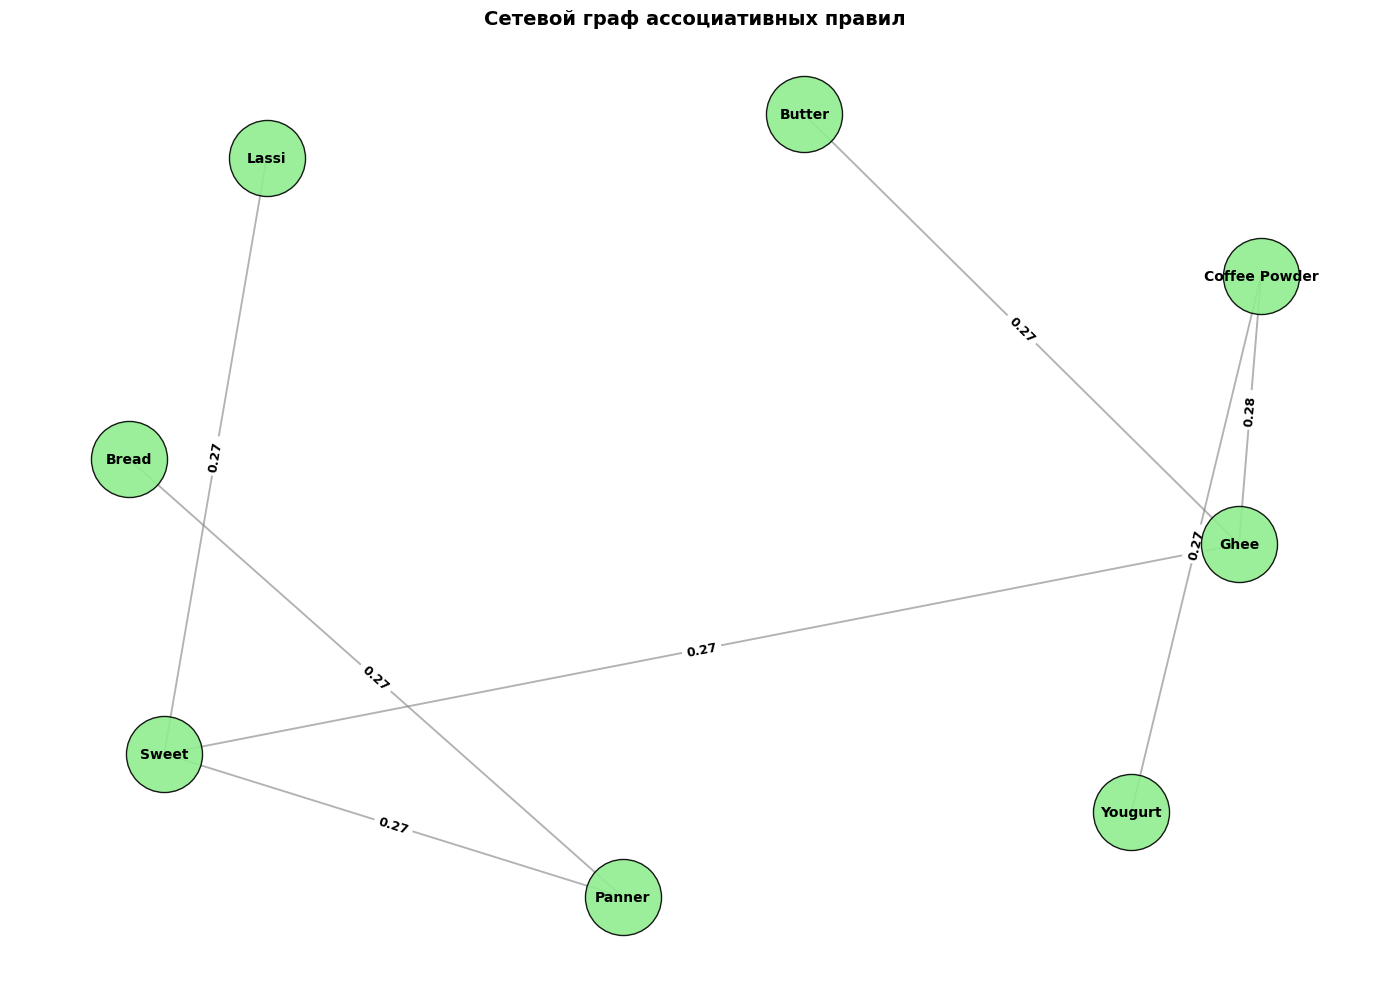

In [9]:
plt.figure(figsize=(12, 8))

G = nx.Graph()

for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['confidence'])


pos = nx.spring_layout(G, k=3, iterations=50)

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, 
                      node_size=3000, 
                      node_color='lightgreen',
                      alpha=0.9,
                      edgecolors='black')

edge_widths = [d['weight'] * 5 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, 
                      width=edge_widths, 
                      alpha=0.6, 
                      edge_color='gray')


nx.draw_networkx_labels(G, pos, 
                       font_size=10, 
                       font_weight='bold',
                       font_family='sans-serif')


edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, 
                            edge_labels=edge_labels,
                            font_size=9,
                            font_weight='bold')

plt.title('Сетевой граф ассоциативных правил', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

На построенном графе можно увидеть связи товаров и значение достоверности ассоциации между ними. То есть по числам на ребрах графа можно определить с какой вероятностью будет куплен товар Б, если покупается товар А.

In [10]:
results = []
supports = [0.01, 0.02, 0.065]
confidences = [0.1, 0.25, 0.3]

for sup in supports:
    for conf in confidences:
        freq_items = apriori(data, min_support=sup, use_colnames=True)
        rule_set = association_rules(freq_items, metric="confidence", min_threshold=conf)

        num_rules = len(rule_set)
        avg_confidence = rule_set['confidence'].mean() if num_rules > 0 else 0
        avg_lift = rule_set['lift'].mean() if num_rules > 0 else 0
        useful_rules = len(rule_set[rule_set['lift'] > 1])

        results.append({
            'support': sup,
            'confidence': conf,
            'num_rules': num_rules,
            'avg_confidence': avg_confidence,
            'avg_lift': avg_lift,
        })

results_df = pd.DataFrame(results)
print(results_df)

   support  confidence  num_rules  avg_confidence  avg_lift
0    0.010        0.10        792        0.236994  0.887077
1    0.010        0.25        209        0.260096  0.969416
2    0.010        0.30          0        0.000000  0.000000
3    0.020        0.10        132        0.256656  0.960664
4    0.020        0.25         99        0.260235  0.971279
5    0.020        0.30          0        0.000000  0.000000
6    0.065        0.10        124        0.257377  0.962355
7    0.065        0.25         99        0.260235  0.971279
8    0.065        0.30          0        0.000000  0.000000


**Выводы:**
- Из данной таблицы можно увидеть, что при максимально достоверности равной 0.03 ассоциативные правила отсутвуют вообще, поэтому и средний lift равен 0
- Максимальное количество правил (792) при самой минимальной поддержке = 0.01, и минимальной достоверности = 0.1
- При повышении порога достоверности (min_confidence) отсеиваются менее надёжные правила, что приводит к росту среднего значения lift остаются только сильные ассоциации (при увелиении с 0,10 до 0,25)
- При увеличении порога поддержки (min_support) резко сокращается количество частых наборов (itemsets) и, как следствие, число правил при этом средний lift снижается, так как теряются редкие, но значимые комбинации

#### Алгоритм FPG

---

In [11]:
df1 = fpgrowth(data, min_support=0.07, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.27)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


     support                  itemsets
0   0.269729           (Coffee Powder)
1   0.271561                  (Cheese)
2   0.264002                  (Butter)
3   0.259993              (Tea Powder)
4   0.268583                   (Bread)
5   0.263429                  (Panner)
6   0.270988                 (Yougurt)
7   0.267209                   (Sweet)
8   0.262856                   (Sugar)
9   0.274654                    (Ghee)
10  0.271332                    (Milk)
11  0.261711                   (Lassi)
12  0.074218  (Coffee Powder, Yougurt)
13  0.075707     (Ghee, Coffee Powder)
14  0.070210   (Coffee Powder, Cheese)
15  0.070439     (Milk, Coffee Powder)
16  0.071469            (Ghee, Cheese)
17  0.070324         (Yougurt, Butter)
18  0.072386            (Ghee, Butter)
19  0.071355    (Bread, Coffee Powder)
20  0.070782           (Bread, Cheese)
21  0.070553          (Bread, Yougurt)
22  0.071813           (Bread, Panner)
23  0.071469           (Sweet, Panner)
24  0.072271         (You

**Вывод**: В результате применения алгоритма FPG было получено также 8 ассоциативных правил. Результаты полность совпадают с результатом алгоритма Apriori




##### Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов

In [12]:
def find_min_support_for_item_count(data, max_items=5, min_supp_start=0.005, 
                                    step=0.001):
    results = {n: None for n in range(1, max_items + 1)}
    current_support = min_supp_start
    
    while current_support >= 0.001 and any(v is None for v in results.values()):
        try:
            frequent_itemsets = fpgrowth(data, min_support=current_support, use_colnames=True)
            frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
            
            for n in range(1, max_items + 1):
                if results[n] is None:  
                    subset = frequent_itemsets[frequent_itemsets['length'] == n]
                    if not subset.empty:
                        results[n] = current_support
                        
            current_support -= step
            
        except Exception as e:
            print(f"Ошибка при support={current_support}: {e}")
            break
    
    return results

min_supports = find_min_support_for_item_count(data)
print("\nРезультаты:")
for n, supp in min_supports.items():
    if supp is not None:
        print(f"Минимальный support для itemset с {n} товарами: {supp:.4f}")
    else:
        print(f"Нет itemset с {n} товарами")


Результаты:
Минимальный support для itemset с 1 товарами: 0.0050
Минимальный support для itemset с 2 товарами: 0.0050
Минимальный support для itemset с 3 товарами: 0.0050
Минимальный support для itemset с 4 товарами: 0.0040
Нет itemset с 5 товарами


##### Предложить и реализовать свой способ визуализации ассоциативных правил и метрик

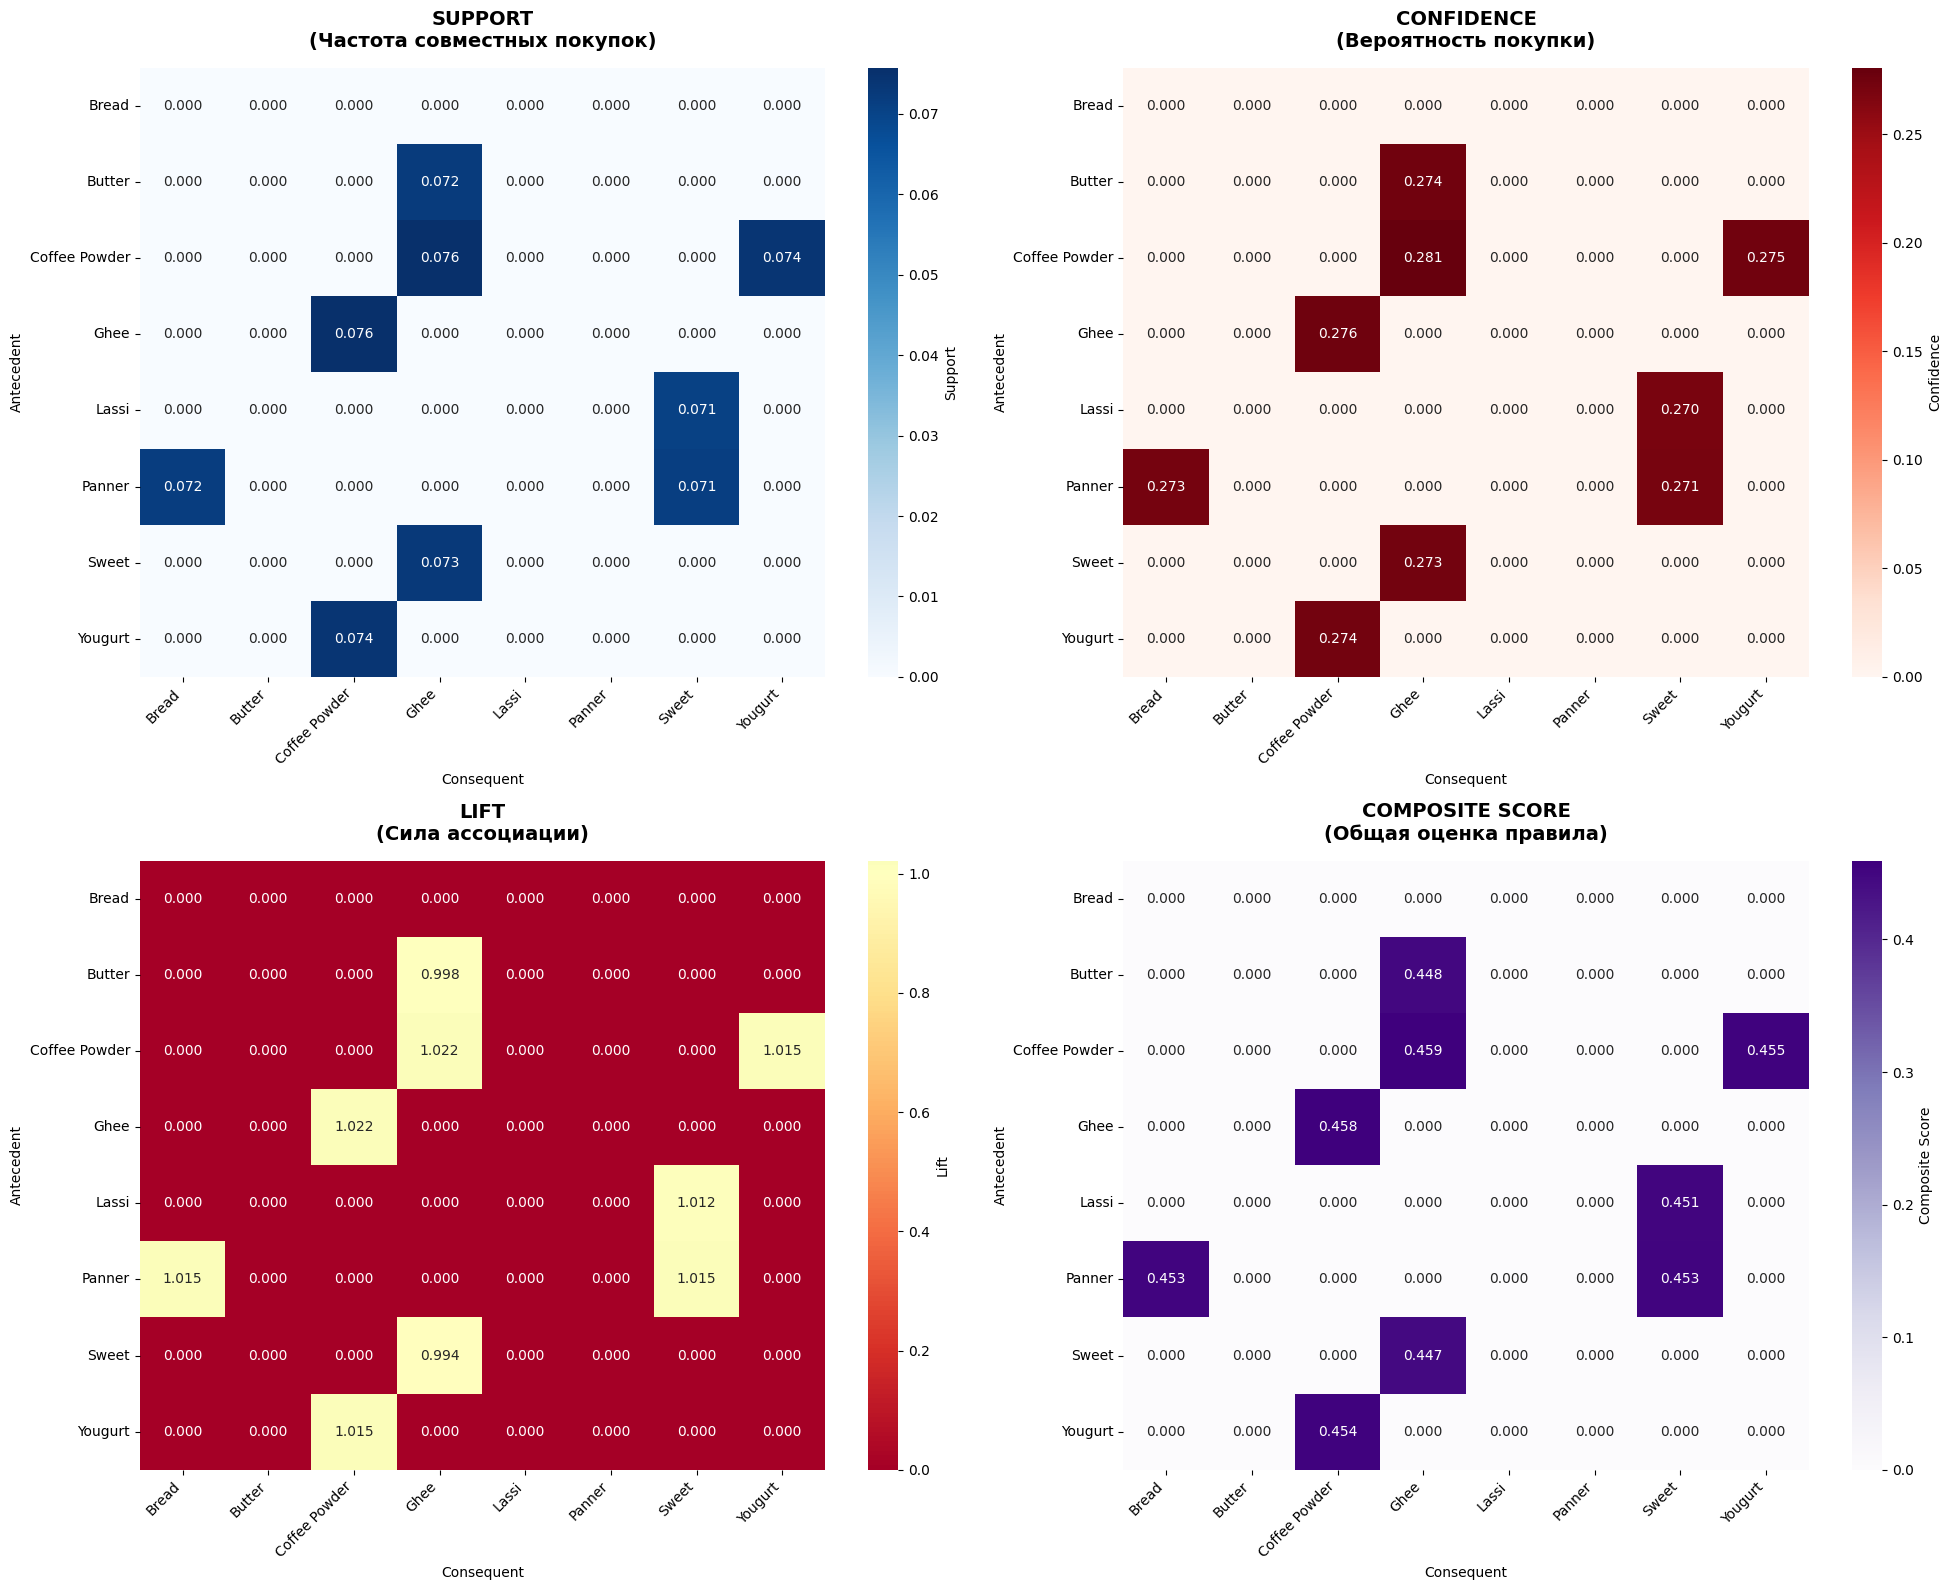

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_four_metrics_heatmap(rules_df):
    """
    4 матрицы: Support, Confidence, Lift и Composite Score
    """
    all_antecedents = set()
    all_consequents = set()
    
    for _, row in rules_df.iterrows():
        all_antecedents.update(row['antecedents'])
        all_consequents.update(row['consequents'])
    
    all_products = sorted(list(all_antecedents.union(all_consequents)))
    
    
    matrix_size = len(all_products)
    support_matrix = np.zeros((matrix_size, matrix_size))
    confidence_matrix = np.zeros((matrix_size, matrix_size))
    lift_matrix = np.zeros((matrix_size, matrix_size))
    composite_matrix = np.zeros((matrix_size, matrix_size))
    
    
    product_to_idx = {product: i for i, product in enumerate(all_products)}
    
    for _, rule in rules_df.iterrows():
        ante = list(rule['antecedents'])[0]
        cons = list(rule['consequents'])[0]
        
        i = product_to_idx[ante]
        j = product_to_idx[cons]
        
        support_matrix[i, j] = rule['support']
        confidence_matrix[i, j] = rule['confidence']
        lift_matrix[i, j] = rule['lift']
        
        composite_matrix[i, j] = (rule['support'] + rule['confidence'] + rule['lift']) / 3
    
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    

    sns.heatmap(support_matrix, 
                xticklabels=all_products,
                yticklabels=all_products,
                annot=True, fmt='.3f',
                cmap='Blues',
                cbar_kws={'label': 'Support'},
                ax=axes[0, 0])
    axes[0, 0].set_title('SUPPORT\n(Частота совместных покупок)', 
                         fontsize=14, fontweight='bold', pad=15)
    axes[0, 0].set_xlabel('Consequent')
    axes[0, 0].set_ylabel('Antecedent')
    

    sns.heatmap(confidence_matrix, 
                xticklabels=all_products,
                yticklabels=all_products,
                annot=True, fmt='.3f',
                cmap='Reds',
                cbar_kws={'label': 'Confidence'},
                ax=axes[0, 1])
    axes[0, 1].set_title('CONFIDENCE\n(Вероятность покупки)', 
                         fontsize=14, fontweight='bold', pad=15)
    axes[0, 1].set_xlabel('Consequent')
    axes[0, 1].set_ylabel('Antecedent')
    

    sns.heatmap(lift_matrix, 
                xticklabels=all_products,
                yticklabels=all_products,
                annot=True, fmt='.3f',
                cmap='RdYlGn',
                center=1.0,
                cbar_kws={'label': 'Lift'},
                ax=axes[1, 0])
    axes[1, 0].set_title('LIFT\n(Сила ассоциации)', 
                         fontsize=14, fontweight='bold', pad=15)
    axes[1, 0].set_xlabel('Consequent')
    axes[1, 0].set_ylabel('Antecedent')
    

    sns.heatmap(composite_matrix, 
                xticklabels=all_products,
                yticklabels=all_products,
                annot=True, fmt='.3f',
                cmap='Purples',
                cbar_kws={'label': 'Composite Score'},
                ax=axes[1, 1])
    axes[1, 1].set_title('COMPOSITE SCORE\n(Общая оценка правила)', 
                         fontsize=14, fontweight='bold', pad=15)
    axes[1, 1].set_xlabel('Consequent')
    axes[1, 1].set_ylabel('Antecedent')

    for ax in axes.flat:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    
    return plt

# Использование - ОДНА СТРОКА:
create_four_metrics_heatmap(rules)
plt.show()

Было реализовано отображение ассоциативных правил и метрик с помощью тепловых карт